PyAutoFit
=========

**PyAutoFit** is a probabilistic programming language which makes is simple to compose, customize and fit complex
models to data.

To illustrate the **PyAutoFit** API, we'll use an illustrative toy model of fitting a one-dimensional Gaussian to
noisy 1D data.

Lets first import autofit and the other libraries we'll need.

In [19]:
# The 5 lines below set up the notebook working directory and can be ignored for the overview.

%matplotlib inline
from pyprojroot import here
workspace_path = str(here())
%cd $workspace_path
print(f"Working Directory has been set to {workspace_path}")

import autofit as af
import autofit.plot as aplt
import numpy as np
import matplotlib.pyplot as plt
from os import path

C:\Users\Jammy\Code\PyAuto\autofit_workspace
Working Directory has been set to C:\Users\Jammy\Code\PyAuto\autofit_workspace


Simple Model
------------

We now load and plot the ``data`` we'll fit:

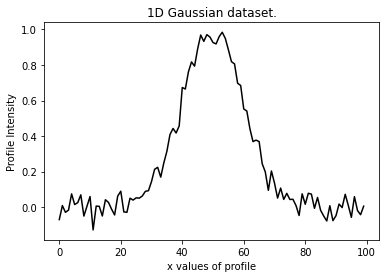

In [20]:
dataset_path = path.join("dataset", "example_1d", "gaussian_x1")
data = af.util.numpy_array_from_json(file_path=path.join(dataset_path, "data.json"))
noise_map = af.util.numpy_array_from_json(
    file_path=path.join(dataset_path, "noise_map.json")
)

xvalues = np.arange(data.shape[0])
plt.plot(xvalues, data, color="k")
plt.title("1D Gaussian dataset.")
plt.xlabel("x values of profile")
plt.ylabel("Profile Intensity")
plt.show()

We define our model, a 1D Gaussian, by writing a Python class using the format below:

In [21]:
class Gaussian:

    def __init__(
        self,
        centre=0.0,  # <- PyAutoFit recognises these
        intensity=0.1,  # <- constructor arguments are
        sigma=0.01,  # <- the Gaussian's parameters.
    ):
        self.centre = centre
        self.intensity = intensity
        self.sigma = sigma

    """
    An instance of the Gaussian class will be available during model fitting.

    This method will be used to fit the model to data and compute a likelihood.
    """

    def profile_from_xvalues(self, xvalues):

        transformed_xvalues = np.subtract(xvalues, self.centre)

        return np.multiply(
            np.divide(self.intensity, self.sigma * np.sqrt(2.0 * np.pi)),
            np.exp(-0.5 * np.square(np.divide(transformed_xvalues, self.sigma))),
        )


By writing the `Gaussian` class in this way, PyAutoFit treats it as a *model-component* which can be fitted to data
via a `NonLinearSearch`.

PyAutoFit calls this a `Model` and it can generate instances of the class from custom *priors*.

In [22]:
model = af.Model(Gaussian)

model.centre = af.UniformPrior(lower_limit=0.0, upper_limit=100.0)
model.intensity = af.UniformPrior(lower_limit=0.0, upper_limit=100.0)
model.sigma = af.GaussianPrior(mean=10.0, sigma=5.0)

print("Model `Gaussian` object: \n")
print(model)

print("\n Model `Gaussian` Parameters: \n")
print(model.centre)
print(model.intensity)
print(model.sigma)

Model `Gaussian` object: 

Gaussian (centre, UniformPrior, lower_limit = 0.0, upper_limit = 100.0), (intensity, UniformPrior, lower_limit = 0.0, upper_limit = 100.0), (sigma, GaussianPrior, mean = 10.0, sigma = 5.0)

 Model `Gaussian` Parameters: 

UniformPrior, lower_limit = 0.0, upper_limit = 100.0
UniformPrior, lower_limit = 0.0, upper_limit = 100.0
GaussianPrior, mean = 10.0, sigma = 5.0


Using this `Model` we can create an `instance` of the model, by mapping a list of unit values to physical values
via the prior on each parameter.

In [23]:
instance = model.instance_from_unit_vector(unit_vector=[0.5, 0.5, 0.5])

print("Model Instance: \n")
print(instance)

print("\nInstance Parameters: \n")
print("x = ", instance.centre)
print("intensity = ", instance.intensity)
print("sigma = ", instance.sigma)

Model Instance: 


Instance Parameters: 

x =  50.0
intensity =  50.0
sigma =  10.0


A *model* fit now only requires that a **PyAutoFit** ``Analysis`` class is written, which combines the data, model and
likelihood function and defines how the *model-fit* is performed using a `NonLinearSearch`.

In [24]:
class Analysis(af.Analysis):

    def __init__(self, data, noise_map):

        self.data = data
        self.noise_map = noise_map

    def log_likelihood_function(self, instance):

        """
        The 'instance' that comes into this method is an instance of the Gaussian class
        above, with the parameters set to values chosen by the non-linear search.

        (The lines below are commented out to text printing later in the Notebook. They
        illustrate how model parameters are passed to the `log_likelihood_function`
        """

        # print("Gaussian Instance:")
        # print("Centre = ", instance.centre)
        # print("Intensity = ", instance.intensity)
        # print("Sigma = ", instance.sigma)

        """
        We fit the data with the Gaussian instance, using its
        "profile_from_xvalues" function to create the model data.
        """

        xvalues = np.arange(self.data.shape[0])

        model_data = instance.profile_from_xvalues(xvalues=xvalues)
        residual_map = self.data - model_data
        chi_squared_map = (residual_map / self.noise_map) ** 2.0
        log_likelihood = -0.5 * sum(chi_squared_map)

        return log_likelihood


The ``Analysis`` class provides a model specific interface between **PyAutoFit** and the modeling software, allowing
it to handle the 'heavy lifting' that comes with writing *model-fitting* software. This includes interfacing with the
non-linear search, model-specific visualization during and the option of outputting results to a queryable database.

Performing a fit with a non-linear search, for example `dynesty` (https://github.com/joshspeagle/dynesty),
is performed as follows:

In [25]:
model = af.Model(Gaussian)

analysis = Analysis(data=data, noise_map=noise_map)

print("Non-linear search running, this will take a minute or so.... \n")

dynesty = af.DynestyStatic(name="example_simple", nlive=50)
result = dynesty.fit(model=model, analysis=analysis)

print("Non-linear search complete!")

2021-05-11 19:54:58,981 - root - INFO - example_simple already completed, skipping non-linear search.


Non-linear search running, this will take a minute or so.... 

Non-linear search complete!


The `Result` object contains information on the model-fit, for example the maximum log likelihood
model and marginalized probability density functions.

In [26]:
print(result.max_log_likelihood_instance)

print("\n Model-fit Max Log-likelihood Parameter Estimates: \n")
print("Centre = ", result.max_log_likelihood_instance.centre)
print("Intensity = ", result.max_log_likelihood_instance.intensity)
print("Sigma = ", result.max_log_likelihood_instance.sigma)


 Model-fit Max Log-likelihood Parameter Estimates: 

Centre =  49.96091963760673
Intensity =  25.18934295159576
Sigma =  10.053753633192343


We can plot this over our data to see the model indeed gives a good fit.

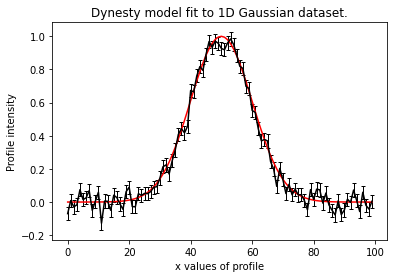

In [27]:
model_data = result.max_log_likelihood_instance.profile_from_xvalues(
    xvalues=np.arange(data.shape[0])
)
plt.errorbar(
    x=xvalues, y=data, yerr=noise_map, color="k", ecolor="k", elinewidth=1, capsize=2
)
plt.plot(xvalues, model_data, color="r")
plt.title("Dynesty model fit to 1D Gaussian dataset.")
plt.xlabel("x values of profile")
plt.ylabel("Profile intensity")
plt.show()
plt.close()

The Probability Density Functions (PDF's) of the results can be plotted using Dynesty's in-built visualization tools,
which are wrapped via the `DynestyPlotter` object.

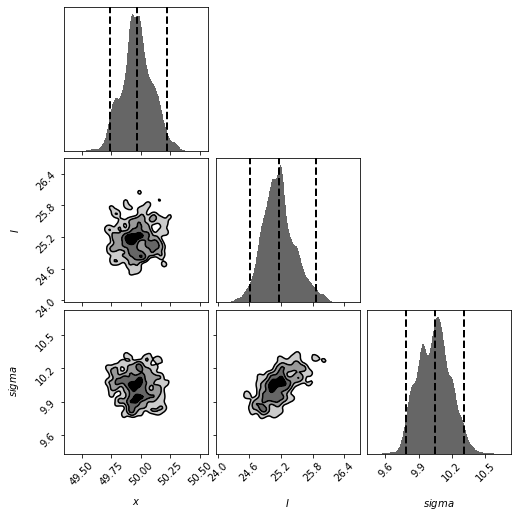

In [28]:
dynesty_plotter = aplt.DynestyPlotter(samples=result.samples)
dynesty_plotter.cornerplot()

Complex Model
-------------

It is straight forward to compose and customize more complex models with **PyAutoFit**.  To demonstrate this, we'll
fit another 1D dataset that contains a Gaussian's and a symmetric Exponential profile.

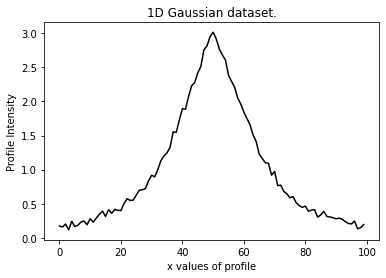

In [29]:
dataset_path = path.join("dataset", "example_1d", "gaussian_x1__exponential_x1")
data = af.util.numpy_array_from_json(file_path=path.join(dataset_path, "data.json"))
noise_map = af.util.numpy_array_from_json(
    file_path=path.join(dataset_path, "noise_map.json")
)

xvalues = np.arange(data.shape[0])
plt.plot(xvalues, data, color="k")
plt.title("1D Gaussian dataset.")
plt.xlabel("x values of profile")
plt.ylabel("Profile Intensity")
plt.show()

To fit the Exponential, we define a second Python class which will act as a *model-component* like the Gaussian did
previously.

In [30]:
class Exponential:

    def __init__(
        self,
        centre=0.0,     # <- PyAutoFit recognises these constructor arguments are the model
        intensity=0.1,  # <- parameters of the Exponential.
        rate=0.01,
    ):
        """Represents a 1D Exponential profile symmetric about a centre, which may be treated as a model-component
        of PyAutoFit the parameters of which are fitted for by a non-linear search.

        Parameters
        ----------
        centre : float
            The x coordinate of the profile centre.
        intensity : float
            Overall intensity normalisation of the `Gaussian` profile.
        ratw : float
            The decay rate controlling has fast the Exponential declines.
        """
        self.centre = centre
        self.intensity = intensity
        self.rate = rate

    def profile_from_xvalues(self, xvalues):
        """
        Calculate the intensity of the profile on a line of Cartesian x coordinates.

        The input xvalues are translated to a coordinate system centred on the Exponential, using its centre.

        Parameters
        ----------
        values : np.ndarray
            The x coordinates in the original reference frame of the grid.
        """
        transformed_xvalues = np.subtract(xvalues, self.centre)
        return self.intensity * np.multiply(
            self.rate, np.exp(-1.0 * self.rate * abs(transformed_xvalues))
        )

We can compose a model from multiple *model-components* using the `Collection` object.

In [31]:
model = af.Collection(gaussian=Gaussian, exponential=Exponential)

An `instance` of the model can be created like we did for a `Model` above.

In [32]:
instance = model.instance_from_vector(vector=[0.1, 0.2, 0.3, 0.4, 0.5, 0.01])

print("Instance Parameters \n")
print("x (Gaussian) = ", instance.gaussian.centre)
print("intensity (Gaussian) = ", instance.gaussian.intensity)
print("sigma (Gaussian) = ", instance.gaussian.sigma)
print("x (Exponential) = ", instance.exponential.centre)
print("intensity (Exponential) = ", instance.exponential.intensity)
print("sigma (Exponential) = ", instance.exponential.rate)

Instance Parameters 

x (Gaussian) =  0.1
intensity (Gaussian) =  0.2
sigma (Gaussian) =  0.3
x (Exponential) =  0.4
intensity (Exponential) =  0.5
sigma (Exponential) =  0.01


There are many options for customizing a model, below we require that:

- The `Gaussian` and `Exponential` share the same centre (reducing the dimensionality of parameter space by 1).
- That the `Gaussian`'s `sigma` value is 10.0 (again reducing the dimensionality by 1).
- That the `rate` parameter of the `Exponential` is above 0.0.

In [33]:
model.gaussian.centre = model.exponential.centre
model.gaussian.sigma = 10.0
model.exponential.add_assertion(model.exponential.rate > 0.0)

The `Analysis` class above was written assuming the input `instance` contained only a single `Gaussian` profile. The
`Collection` contains multiple profiles, thus we must update the `Analysis` class to reflect this.

In [34]:
class Analysis(af.Analysis):

    def __init__(self, data, noise_map):

        self.data = data
        self.noise_map = noise_map

    def log_likelihood_function(self, instance):

        xvalues = np.arange(self.data.shape[0])

        """
        The instance, which now contains the `gaussian` and `exponential`, can be iterated over
        and summed so our model-data is the combination of the two.
        """

        model_data = sum(
            [profile.profile_from_xvalues(xvalues=xvalues) for profile in instance]
        )

        residual_map = self.data - model_data
        chi_squared_map = (residual_map / self.noise_map) ** 2.0
        log_likelihood = -0.5 * sum(chi_squared_map)

        return log_likelihood

We can now fit our more complex model as we did previously. Lets use the MCMC algorithm
`Emcee` (https://github.com/dfm/emcee) this time.

In [35]:
analysis = Analysis(data=data, noise_map=noise_map)

print("Non-linear search running, this will take a minute or so.... \n")

emcee = af.Emcee(name="example_complex", nwalkers=30, nsteps=200)
result = emcee.fit(model=model, analysis=analysis)

print("Non-linear search complete!")

2021-05-11 19:55:20,165 - root - INFO - example_complex already completed, skipping non-linear search.


Non-linear search running, this will take a minute or so.... 

Non-linear search complete!


Because our fit used a `Collection` (as opposed to a `Model`) the `Result` instance returns the
results for both the `gaussian` and `exponential`.

In [36]:
max_log_likelihood_instance = result.max_log_likelihood_instance

print("Max Log Likelihood `Gaussian` Instance:")
print("Centre = ", max_log_likelihood_instance.gaussian.centre)
print("Intensity = ", max_log_likelihood_instance.gaussian.intensity)
print("Sigma = ", max_log_likelihood_instance.gaussian.sigma, "\n")
print("Max Log Likelihood Exponential Instance:")
print("Centre = ", max_log_likelihood_instance.exponential.centre)
print("Intensity = ", max_log_likelihood_instance.exponential.intensity)
print("Sigma = ", max_log_likelihood_instance.exponential.rate, "\n")

Max Log Likelihood `Gaussian` Instance:
Centre =  49.925907568583426
Intensity =  25.067815104249963
Sigma =  10.0 

Max Log Likelihood Exponential Instance:
Centre =  49.925907568583426
Intensity =  39.88332141767394
Sigma =  0.050285224361916174 



We can again use this to plot the model fit.

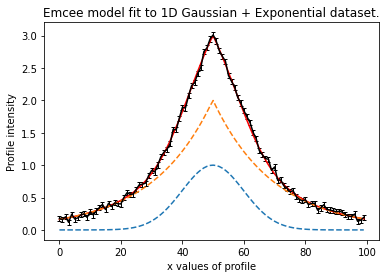

In [37]:
model_gaussian = max_log_likelihood_instance.gaussian.profile_from_xvalues(
    xvalues=np.arange(data.shape[0])
)
model_exponential = max_log_likelihood_instance.exponential.profile_from_xvalues(
    xvalues=np.arange(data.shape[0])
)
model_data = model_gaussian + model_exponential

plt.errorbar(
    x=xvalues, y=data, yerr=noise_map, color="k", ecolor="k", elinewidth=1, capsize=2
)
plt.plot(range(data.shape[0]), model_data, color="r")
plt.plot(range(data.shape[0]), model_gaussian, "--")
plt.plot(range(data.shape[0]), model_exponential, "--")
plt.title("Emcee model fit to 1D Gaussian + Exponential dataset.")
plt.xlabel("x values of profile")
plt.ylabel("Profile intensity")
plt.show()
plt.close()

The Probability Density Functions (PDF's) of the results can be plotted using the Emcee's visualization
tool `corner.py`, which is wrapped via the `EmceePlotter` object.

2021-05-11 19:55:27,389 - root - WARNING - Too few points to create valid contours


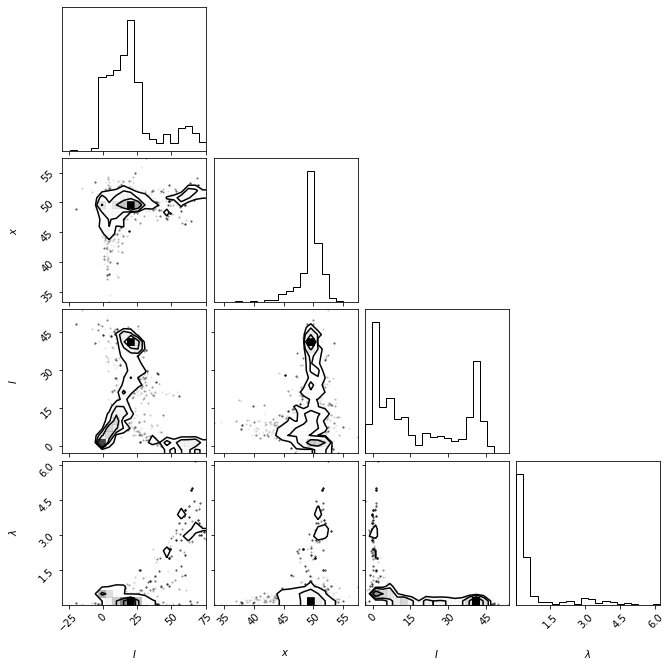

In [38]:
emcee_plotter = aplt.EmceePlotter(samples=result.samples)
emcee_plotter.corner()

Congratulations, you've  completed the **PyAutoFit** introduction!

So, What Next?
--------------

This notebook has given you an overview of the **PyAutoFit** API. This API acts as the foundation for using many of
**PyAutoFit**'s advanced features, such as:

- [Database tools for loading and manipulating large libraries of results in a Jupyter notebook.](https://pyautofit.readthedocs.io/en/latest/overview/database.html)
- [Performing massively paralle grid searches of non-linear searches.](https://pyautofit.readthedocs.io/en/latest/features/search_grid_search.html)
- [Chaining searches back-to-back to break a complex model-fitting procedure into sequence of simpler model-fits](https://pyautofit.readthedocs.io/en/latest/features/search_chaining.html)
- [Sensitivity mapping over a model or dataset to determine when more complex model features become detectable](https://pyautofit.readthedocs.io/en/latest/features/sensitivity_mapping.html)]

We recommend you next start the **HowToFit** Jupyter notebook tutorials, which provide a detailed description of the
**PyAutoFit** API, give more details on how to compose and fit models and a more detailed description of the
`Result` object and database analysis tools.

If you wish to add your own *model-component* to your `autofit_workspace` to perform your own model-fitting task,
checkout the script `autofit_workspace/notebooks/overview/new_model_component/new_model_compnent.ipynb`, which explains
how to set up the **PyAutoFit** configuration files associated with your model.

You can install **PyAutoFit** on your system and clone the `autofit_workspace` and `howtofit` tutorials
following the instructions on our readthedocs:

 https://pyautofit.readthedocs.io/en/latest/installation/overview.html

Alternatively, you can begin the tutorials on Binder by going to the folder `howtofit/chapter_1_introduction` at
the following link `https://mybinder.org/v2/gh/Jammy2211/autofit_workspace/HEAD`.